<a href="https://colab.research.google.com/github/skydvn/Compression-aided-FL-Optimization/blob/main/DDPG_UserAllocation_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment

In [ ]:
import numpy as np
import math

In [ ]:
dtype = np.float32

class SumRate():
    def __init__(self, MAX_EP_STEPS, gArray, r_req, weight, pel):
        self.H = gArray
        self.I = self.H.shape[0]
        self.r_req = r_req
        self.weight = weight        
        self.n0 = 0.1*1e-6
        self.stopEps = 1e-6
        self.pMax = 1e-3*np.array([0.7, 0.8, 0.9, 1.0])
        self.pMin = np.zeros([1,self.I])
        self.MAX_EP_STEPS = MAX_EP_STEPS
        self.pel = pel     
        self.state_walk = 0;
                
        self.action_low = self.pMin
        self.action_high = self.pMax        
        H_space = np.reshape(self.H, (1, self.I*self.I))
        d_rate = -np.ones((1,self.I)) * 1
        self.observation_space = np.concatenate((H_space,d_rate),axis=1)
        

    def step(self, action, state):
      state_rs = np.reshape(state,(self.I+1,self.I))
      H = state_rs[0:self.I,0:self.I]
      d_rate = state_rs[self.I, 0:self.I]
      diagH = np.diag(H)
      print("Action is: {}".format(action))
      rate = np.log(self.n0 + np.matmul(action,H.transpose())) \
          - np.log(self.n0 + action*diagH)        
      print("rate is: {}".format(rate))
      sumrate = np.sum(weight * rate) * math.log2(math.exp(1))
      reward = sumrate \
          - np.sum(pel * (sum(d_rate < 0) * d_rate**2));
      
      # define the next state
      d_rate = rate - self.r_req
      d_rate = d_rate.reshape((1,4))
      print(np.shape(d_rate))
      state_next = np.concatenate((H, d_rate), axis=0)
      state_next = np.reshape(state_next,(1,self.I*self.I+self.I))
  
      # return the done flag
      self.state_walk += 1
      if self.state_walk > MAX_EP_STEPS:
          done = True
      else: done = False
      return state_next, reward, done

    def reset(self):
        d_rate = -np.ones((1,self.I)) * 1
        hnx1 = np.random.randn(self.I, self.I)
        hnx2 = np.random.randn(self.I, self.I)
        fading_n = hnx1 ** 2 + hnx2 ** 2        
        print(np.shape(d_rate))
        state_next = np.concatenate((self.H * fading_n, d_rate), axis=0)
        state = np.reshape(state_next,(1,self.I*self.I+self.I))
        
        return state

DDPG

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
# from env_SumRate import SumRate
import matplotlib.pyplot as plt

# import gym
import argparse
import numpy as np
import random
from collections import deque

tf.keras.backend.set_floatx('float64')

# parser = argparse.ArgumentParser()
# parser.add_argument('--gamma', type=float, default=0.99)
# parser.add_argument('--actor_lr', type=float, default=0.0005)
# parser.add_argument('--critic_lr', type=float, default=0.001)
# parser.add_argument('--batch_size', type=int, default=64)
# parser.add_argument('--tau', type=float, default=0.05)
# parser.add_argument('--train_start', type=int, default=2000)

# args = parser.parse_args()
class Configuration: 
  def __init__(self):
    self.gamma = 0.99
    self.actor_lr = 0.0005
    self.critic_lr = 0.001
    self.batch_size = 64
    self.tau = 0.05
    self.train_start = 2000

args = Configuration()
print(args.batch_size)

64


# Actor Critic Definition


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.buffer = deque(maxlen=capacity)
    
    def put(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self):
        sample = random.sample(self.buffer, args.batch_size)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(args.batch_size, -1)
        next_states = np.array(next_states).reshape(args.batch_size, -1)
        return states, actions, rewards, next_states, done
    
    def size(self):
        return len(self.buffer)

class Critic:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(args.critic_lr)

    def create_model(self):
        state_input = Input((self.state_dim,))
        s1 = Dense(64, activation='relu')(state_input)
        s2 = Dense(32, activation='relu')(s1)
        action_input = Input((self.action_dim,))
        a1 = Dense(32, activation='relu')(action_input)
        c1 = concatenate([s2, a1], axis=-1)
        c2 = Dense(16, activation='relu')(c1)
        output = Dense(1, activation='linear')(c2)
        return tf.keras.Model([state_input, action_input], output)
    
    def predict(self, inputs):
        return self.model.predict(inputs)
    
    def q_grads(self, states, actions):
        actions = tf.convert_to_tensor(actions)
        with tf.GradientTape() as tape:
            tape.watch(actions)
            q_values = self.model([states, actions])
            q_values = tf.squeeze(q_values)
        return tape.gradient(q_values, actions)

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, actions, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model([states, actions], training=True)
            assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

class Actor:
    def __init__(self, state_dim, action_dim, action_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(args.actor_lr)

    def create_model(self):
        return tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_dim, activation='sigmoid'),
            Lambda(lambda x: x * self.action_bound)
        ])

    def train(self, states, q_grads):
        with tf.GradientTape() as tape:
            grads = tape.gradient(self.model(states), self.model.trainable_variables, -q_grads)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
    
    def predict(self, state):
        return self.model.predict(state)

    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        return self.model.predict(state)[0]

In [ ]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[1]
        self.action_dim = self.env.action_low.shape[1]
        self.action_bound = self.env.action_high

        self.buffer = ReplayBuffer()

        self.actor = Actor(self.state_dim, self.action_dim, self.action_bound)
        self.critic = Critic(self.state_dim, self.action_dim)
        
        self.target_actor = Actor(self.state_dim, self.action_dim, self.action_bound)
        self.target_critic = Critic(self.state_dim, self.action_dim)

        actor_weights = self.actor.model.get_weights()
        critic_weights = self.critic.model.get_weights()
        self.target_actor.model.set_weights(actor_weights)
        self.target_critic.model.set_weights(critic_weights)
        
    
    def target_update(self):
        actor_weights = self.actor.model.get_weights()
        t_actor_weights = self.target_actor.model.get_weights()
        critic_weights = self.critic.model.get_weights()
        t_critic_weights = self.target_critic.model.get_weights()

        for i in range(len(actor_weights)):
            t_actor_weights[i] = args.tau * actor_weights[i] + (1 - args.tau) * t_actor_weights[i]

        for i in range(len(critic_weights)):
            t_critic_weights[i] = args.tau * critic_weights[i] + (1 - args.tau) * t_critic_weights[i]
        
        self.target_actor.model.set_weights(t_actor_weights)
        self.target_critic.model.set_weights(t_critic_weights)


    def td_target(self, rewards, q_values, dones):
        targets = np.asarray(q_values)
        for i in range(q_values.shape[0]):
            if dones[i]:
                targets[i] = rewards[i]
            else:
                targets[i] = args.gamma * q_values[i]
        return targets

    def list_to_batch(self, list):
        batch = list[0]
        for elem in list[1:]:
            batch = np.append(batch, elem, axis=0)
        return batch
    
    def ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return x + rho * (mu-x) * dt + sigma * np.sqrt(dt) * np.random.normal(size=dim)
    
    # Training phase of an Agent
    def replay(self):
        for _ in range(10):
            states, actions, rewards, next_states, dones = self.buffer.sample()
            target_q_values = self.target_critic.predict([next_states, self.target_actor.predict(next_states)])
            td_targets = self.td_target(rewards, target_q_values, dones)
            
            #### Primary Network ####
            # Critic Update
            self.critic.train(states, actions, td_targets)
            
            s_actions = self.actor.predict(states)
            s_grads = self.critic.q_grads(states, s_actions)
            grads = np.array(s_grads).reshape((-1, self.action_dim))

            # Actor Update
            self.actor.train(states, grads)

            #### Target Network  ####
            self.target_update()

    def train(self, max_episodes=100):
        ep_rewardall = []
        for ep in range(max_episodes):
            episode_reward, done = 0, False

            state = self.env.reset()
            bg_noise = np.zeros(self.action_dim)
            while not done:
                # self.env.render()
                action = self.actor.get_action(state)
                noise = self.ou_noise(bg_noise, dim=self.action_dim)
                action = np.clip(action + noise, 0, self.action_bound)  # noise is created here and make action less than zero

                next_state, reward, done = self.env.step(action, state)
                ##########################################
                H = [[0.4310, 0.0002, 0.0129, 0.0011],
                      [0.0002, 0.3018, 0.0005, 0.0031], 
                      [0.2605, 0.0008, 0.4266, 0.0099],
                      [0.0039, 0.0054, 0.1007, 0.0634]]
                gArray = np.array(H)
                print(np.shape(gArray))
                H = gArray
                I = H.shape[0]
                r_req = 1e-3*np.array([0.7, 0.8, 0.9, 1.0])
                weight = np.array([1,1,1,1])        
                n0 = 0.1*1e-6
                stopEps = 1e-6
                pMax = 1e-3*np.array([0.7, 0.8, 0.9, 1.0])
                pMin = 1e-8*np.ones([1,I])
                MAX_EP_STEPS = 100
                pel = 1e1     
                step = 0;
                state = np.reshape(state,(I+1,I))
                H = state[0:I,0:I]
                d_rate = state[I, 0:I]
                diagH = np.diag(H)
                print("Action is: {}".format(action))
                rate = np.log(n0 + np.matmul(action,H.transpose())) \
                    - np.log(n0 + action*diagH)        
                print("rate is: {}".format(rate))
                sumrate = np.sum(weight * rate) * math.log2(math.exp(1))
                reward = sumrate \
                    - np.sum(pel * (sum(d_rate < 0) * d_rate**2));
                
                # define the next state
                d_rate = rate - r_req
                d_rate = d_rate.reshape((1,4))
                print(np.shape(d_rate))
                state_next = np.concatenate((H, d_rate), axis=0)
                state_next = np.reshape(state_next,(1,I*I+I))
            
                # return the done flag
                step += 1
                if step > MAX_EP_STEPS:
                    done = True
                next_state = state_next

                self.buffer.put(state, action, (reward+8)/8, next_state, done)
                bg_noise = noise
                episode_reward += reward
                state = next_state
            if self.buffer.size() >= args.batch_size and self.buffer.size() >= args.train_start:
                self.replay()   
            ep_rewardall.append(episode_reward)
            print('EP{} EpisodeReward={}'.format(ep, episode_reward))
            # wandb.log({'Reward': episode_reward})
            
        return ep_rewardall


def main():    
    ################## training
    H = [[0.4310, 0.0002, 0.0129, 0.0011],
     [0.0002, 0.3018, 0.0005, 0.0031],
     [0.2605, 0.0008, 0.4266, 0.0099],
     [0.0039, 0.0054, 0.1007, 0.0634]]
    gArray = np.array(H)
    MAX_EP_STEPS = 100
    r_req = 1e-3*np.array([0.7, 0.8, 0.9, 1.0])
    weight = np.array([1,1,1,1])
    pel = 1e1
    
    env_sr = SumRate(MAX_EP_STEPS, gArray, r_req, weight, pel)
    agent = Agent(env_sr)
    ep_rewardall = agent.train(max_episodes=50)
    
    ### plot
    plt.plot(ep_rewardall, "^-")
    plt.xlabel("Episode")
    plt.ylabel(" Epsiodic Reward")
    plt.show()
    
    #env_name = 'Pendulum-v0'
    # env = gym.make(env_name)
    # agent = Agent(env)
    # agent.train(max_episodes=50)

(1, 4)
Action is: [0.     0.     0.0009 0.001 ]
rate is: [4.82478647 4.12472796 0.10589777 0.54769612]
(1, 4)
(4, 4)
Action is: [0.     0.     0.0009 0.001 ]
rate is: [4.82478647 4.12472796 0.10589777 0.54769612]
(1, 4)
Action is: [0.     0.0008 0.0009 0.    ]
rate is: [4.81712807e+00 1.01418940e-01 1.57306884e-03 6.46263696e+00]
(1, 4)
(4, 4)
Action is: [0.     0.0008 0.0009 0.    ]
rate is: [4.81712807e+00 1.01418940e-01 1.57306884e-03 6.46263696e+00]
(1, 4)
Action is: [0.0007 0.     0.0009 0.    ]
rate is: [0.46902078 3.18911261 0.85621294 6.52377023]
(1, 4)
(4, 4)
Action is: [0.0007 0.     0.0009 0.    ]
rate is: [0.46902078 3.18911261 0.85621294 6.52377023]
(1, 4)
Action is: [0.     0.0008 0.0009 0.    ]
rate is: [4.81712807e+00 1.01418940e-01 1.57306884e-03 6.46263696e+00]
(1, 4)
(4, 4)
Action is: [0.     0.0008 0.0009 0.    ]
rate is: [4.81712807e+00 1.01418940e-01 1.57306884e-03 6.46263696e+00]
(1, 4)
Action is: [0.     0.0008 0.0009 0.001 ]
rate is: [4.83996983 0.27113894 0.10

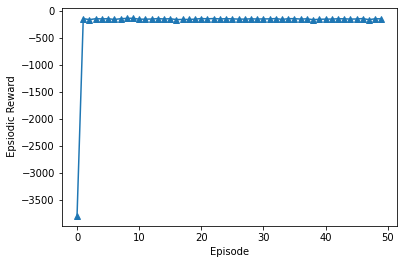

In [ ]:
################## training
H = np.array([[0.4310, 0.0002, 0.0129, 0.0011],
              [0.0002, 0.3018, 0.0005, 0.0031],
              [0.2605, 0.0008, 0.4266, 0.0099],
              [0.0039, 0.0054, 0.1007, 0.0634]]) 
gArray = np.array(H)
MAX_EP_STEPS = 100
r_req = 1e-3*np.array([0.7, 0.8, 0.9, 1.0])
weight = np.array([1,1,1,1])
pel = 1e1

env_sr = SumRate(MAX_EP_STEPS, gArray, r_req, weight, pel)
agent = Agent(env_sr)
ep_rewardall = agent.train(max_episodes=50)

### plot
plt.plot(ep_rewardall, "^-")
plt.xlabel("Episode")
plt.ylabel(" Epsiodic Reward")
plt.show()

In [ ]:
###########################################
H = [[0.4310, 0.0002, 0.0129, 0.0011],
      [0.0002, 0.3018, 0.0005, 0.0031], 
      [0.2605, 0.0008, 0.4266, 0.0099],
      [0.0039, 0.0054, 0.1007, 0.0634]]
gArray = np.array(H)
print(np.shape(gArray))
H = gArray
I = H.shape[0]
r_req = 1e-3*np.array([0.7, 0.8, 0.9, 1.0])
weight = np.array([1,1,1,1])        
n0 = 0.1*1e-6
stopEps = 1e-6
pMax = 1e-3*np.array([0.7, 0.8, 0.9, 1.0])
pMin = 1e-8*np.ones([1,I])
MAX_EP_STEPS = 100
pel = 1e1     
step = 0;
##########################################
state = np.reshape(state,(I+1,I))
H = state[0:I,0:I]
d_rate = state[I][0:I]
diagH = np.diag(H)

print("Action is: {}".format(action))
rate = np.log(n0 + np.matmul(action,H.transpose())) \
    - np.log(n0 + action*diagH)        
print("rate is: {}".format(rate))
# print("diagH is: {}".format(diagH))
# print("n0 is: {}".format(n0))
# print("Log1 is: {}".format(n0 + np.matmul(action,H.transpose())))
# print("Log2 is: {}".format(n0 + action*diagH))
sumrate = np.sum(weight * rate) * math.log2(math.exp(1))
reward = sumrate \
    - np.sum(pel * (sum(d_rate < 0) * d_rate**2));

# define the next state
d_rate = rate - r_req
d_rate = d_rate.reshape((1,4))
print("d_rate is: {}".format(d_rate))
print(np.shape(d_rate))

state_next = np.concatenate((H, d_rate), axis=0)
print("state_next is: {}".format(state_next))
state_next = np.reshape(state_next,(1,I*I+I))
# return the done flag
step += 1
if step > MAX_EP_STEPS:
    done = True
next_state = state_next

self.buffer.put(state, action, (reward+8)/8, next_state, done)
bg_noise = noise
episode_reward += reward
state = next_state

In [ ]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])
c = np.concatenate((a, b), axis=0)
print(c)
print(np.shape(c))

[[1 2]
 [3 4]
 [5 6]]
(3, 2)


In [ ]:
I = 4
d_rate = -np.ones((1,I)) * 1
hnx1 = np.random.randn(I, I)
hnx2 = np.random.randn(I, I)
fading_n = hnx1 ** 2 + hnx2 ** 2        
state_next = np.concatenate((H * fading_n, d_rate), axis=0)
state = np.reshape(state_next,(1,I*I+I))

In [ ]:
print(state_next)

In [ ]:
print(state_next[0])